# Revenue Forecasting in a Tax Administration — End-to-End

**Objective:** Build a reproducible revenue forecasting pipeline using monthly revenue data (5 years), feature engineering, statistical tests, and six machine learning algorithms. This notebook is designed for classroom use — each step contains code and explanatory notes so students can follow along and adapt to real tax data.

**What you will learn:**

- Simulating or loading monthly revenue + macro / compliance drivers
- Exploratory Data Analysis (EDA)
- Data cleaning and transformations
- Feature engineering for time series (lags, rolling stats, seasonality)
- Statistical feature selection (OLS p-values)
- Training and cross-validating multiple ML models (time-series CV)
- Hold-out evaluation and model selection (RMSE, MAPE, R²)
- Recursive multi-step forecasting with the best model
- Practical notes on productionising the model

**Prerequisites:** Python packages: pandas, numpy, matplotlib, scikit-learn, statsmodels, joblib, nbformat.

Run each code cell in order. Replace the simulated dataset with your real MRA monthly series and driver variables when ready.


In [2]:
# 1) Setup: imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# sklearn & statsmodels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm

print('Libraries imported successfully')

Libraries imported successfully


## 2) Simulate 5 years of monthly revenue data (or load your data)

Below we create a plausible synthetic dataset with monthly revenue and drivers (GDP growth, CPI, FX, fuel index, audits, compliance actions, and a policy change). **In your class exercise**: either use this simulated data or replace this block with `pd.read_csv('your_revenue.csv')`.

In [ ]:
# Simulate data (Jan 2020 - Dec 2024)
rng = np.random.default_rng(42)
dates = pd.date_range(start='2020-01-01', end='2024-12-01', freq='MS')
n = len(dates)
month = dates.month.values
t = np.arange(n)

# Drivers (synthetic)
gdp_growth = 0.04 + 0.01 * np.sin(2 * np.pi * month / 12) + rng.normal(0, 0.005, n)
cpi_inflation = 0.10 + 0.02 * np.cos(2 * np.pi * (month - 3) / 12) + rng.normal(0, 0.01, n)
fx_mwk_usd = 750 + 5 * t + 25 * np.sin(2 * np.pi * month / 6) + rng.normal(0, 15, n)
fuel_price_index = 100 + 0.5 * t + 5 * np.sin(2 * np.pi * month / 12) + rng.normal(0, 2, n)
audits_launched = rng.poisson(10 + 2 * np.sin(2 * np.pi * month / 12), n)
compliance_actions = rng.poisson(25 + 3 * np.cos(2 * np.pi * (month-2) / 12), n)
policy_change = (dates >= '2022-07-01').astype(int)

# Revenue generation (synthetic signal)
base = 120_000
trend = 900 * t
seasonality = 7000 * np.sin(2 * np.pi * month / 12) + 4000 * np.cos(2 * np.pi * month / 12)
macro_effects = (
    20_000 * gdp_growth
    - 10_000 * cpi_inflation
    + 5 * fx_mwk_usd
    + 100 * fuel_price_index
    + 300 * audits_launched
    + 200 * compliance_actions
    + 12_000 * policy_change
)
noise = rng.normal(0, 12_000, n)
revenue = np.maximum(base + trend + seasonality + macro_effects + noise, 10_000)

df = pd.DataFrame({
    'date': dates,
    'year': dates.year,
    'month': dates.month,
    'gdp_growth': gdp_growth,
    'cpi_inflation': cpi_inflation,
    'fx_mwk_usd': fx_mwk_usd,
    'fuel_price_index': fuel_price_index,
    'audits_launched': audits_launched,
    'compliance_actions': compliance_actions,
    'policy_change': policy_change,
    'revenue_mwk_millions': revenue
})

# Inject a few missing values to demonstrate cleaning
for col in ['gdp_growth', 'cpi_inflation', 'fx_mwk_usd']:
    idx = rng.choice(n, size=3, replace=False)
    df.loc[idx, col] = np.nan

# Save to CSV for classroom
Path('revenue_forecasting_files').mkdir(exist_ok=True)
df.to_csv('revenue_forecasting_files/tax_revenue_simulated.csv', index=False)
df.head()

In [25]:
df = pd.read_csv(r"C:\Users\kmalangwasila\OneDrive - Malawi Revenue Authority\Desktop\ML Revene Forecasting\tax_revenue_simulated.csv")

In [26]:
df.head()

,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,1,0.046524,0.093171,756.298173,105.112003,10,32,0,119878.619410
1,2020-02-01,2020,2,1,0.043460,0.113972,NaN,105.268892,13,27,0,161833.384408
2,2020-03-01,2020,3,1,0.053752,NaN,763.299950,105.178146,11,15,0,152561.521181
3,2020-04-01,2020,4,2,0.053363,0.123183,763.737179,108.042704,9,23,0,139954.070513
4,2020-05-01,2020,5,2,0.035245,0.117112,760.876034,105.357513,14,26,0,131107.841131


In [27]:
df.tail()

,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
55,2024-08-01,2024,8,3,0.028145,0.077385,1049.239454,121.861580,5,21,1,185284.601636
56,2024-09-01,2024,9,3,0.028624,0.082327,1053.686369,118.705422,6,26,1,216822.338593
57,2024-10-01,2024,10,4,0.038814,0.082898,1015.749239,123.844541,9,20,1,206739.375195
58,2024-11-01,2024,11,4,0.030671,0.106018,1016.569790,124.375171,10,21,1,217645.513568
59,2024-12-01,2024,12,4,0.044841,0.097606,1049.287392,128.441121,9,35,1,203129.381444


## 3) Exploratory Data Analysis (EDA)

Inspect the data structure, summary statistics, and visualize the revenue time-series. Look for trends, seasonality, and obvious anomalies.

In [ ]:
# Basic checks
print(df.info())
display(df.describe().round(2))

# Plot revenue
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['revenue_mwk_millions'])
plt.title('Monthly Revenue (MWK millions)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


# Combine year and month into a datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['revenue_mwk_millions'], marker='o')
plt.title('Monthly Revenue (MWK millions)')
plt.xlabel('Date')
plt.ylabel('Revenue (MWK millions)')
plt.tight_layout()
plt.show()


In [35]:
df.head()

,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,1,0.046524,0.093171,756.298173,105.112003,10,32,0,119878.619410
1,2020-02-01,2020,2,1,0.043460,0.113972,NaN,105.268892,13,27,0,161833.384408
2,2020-03-01,2020,3,1,0.053752,NaN,763.299950,105.178146,11,15,0,152561.521181
3,2020-04-01,2020,4,2,0.053363,0.123183,763.737179,108.042704,9,23,0,139954.070513
4,2020-05-01,2020,5,2,0.035245,0.117112,760.876034,105.357513,14,26,0,131107.841131


In [39]:
df.describe() # Generates summary statistics of the DataFrame for all numeric columns

,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
count,60,60.000000,60.000000,60.000000,57.000000,57.000000,57.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2022-06-16 15:12:00,2022.000000,6.500000,2.500000,0.039828,0.098116,898.654090,114.714519,10.100000,25.066667,0.500000,174310.931669
min,2020-01-01 00:00:00,2020.000000,1.000000,1.000000,0.027075,0.070664,756.298173,96.263682,2.000000,14.000000,0.000000,119878.619410
25%,2021-03-24 06:00:00,2021.000000,3.750000,1.750000,0.032433,0.082898,823.600178,107.727916,7.000000,21.000000,0.000000,156660.592175
50%,2022-06-16 00:00:00,2022.000000,6.500000,2.500000,0.039397,0.096773,897.355729,114.088229,10.000000,26.000000,0.500000,172158.919831
75%,2023-09-08 12:00:00,2023.000000,9.250000,3.250000,0.045708,0.112992,974.329835,122.148772,13.000000,29.000000,1.000000,188332.553671
max,2024-12-01 00:00:00,2024.000000,12.000000,4.000000,0.054296,0.124344,1053.686369,129.131210,16.000000,36.000000,1.000000,217645.513568
std,NaN,1.426148,3.481184,1.127469,0.008168,0.016095,87.591576,8.712974,3.442998,5.917130,0.504219,23712.418411


# For Montly Revenue Data:

#25% (Q1) = 156,660M = 25% of the months had revenue below this level or 75% had revenues above 156M

#50% (Median) = 172,159M - Half the months had revenue below, half above this

#75% (Q3) 188,333M - 75% of months were below this level

#IQR = Q3-Q1 = ~31,672M - typical monthly variation

#Interpretation: Revenues are growing steadily (median close to mean = 174,311M), distribution is fairly balanced

#Outliers may reflect policy changes, one-off large taxpayer payments, or compliance drives.

# Macroeconomic Drivers
# GDP, inflation, and exchange rate are significant macro predictors.
# GDP Growth:

#Q1 = 3.2%, Median = 3.9%, Q3 = 4.6%.

#Revenue forecasts will respond to higher GDP growth → more economic activity → higher taxes.

#Q1 (25th percentile) = 3.2% → 25% of the observed months had GDP growth at or below 3.2%.

#Median (50th percentile) = 3.9% → half of the observations had GDP growth at or below 3.9%, and half above.

#Q3 (75th percentile) = 4.6% → 75% of the observations recorded GDP growth at or below 4.6%.

#Interpretation:
#Revenue forecasts are positively correlated with GDP growth. 
#Higher GDP growth implies stronger economic activity, leading to higher tax collections. 
#For instance, periods above 4.6% GDP growth (top quartile) may drive 
#significant upward shifts in tax revenue performance.

# Inflation (CPI):

#Q1 = 8.3%, Median = 9.7%, Q3 = 11.3%.

#Inflation may inflate nominal revenue but can distort real growth.
#Q1 = 8.3%, Median = 9.7%, Q3 = 11.3%.

#25% of the time inflation was below 8.3%.
#Half the time, inflation was below 9.7%.
#75% of the time, inflation was below 11.3%.
#Interpretation:
#Higher inflation generally erodes real revenue, but nominal revenue may increase if tax bases 
#(like VAT and excise) are directly linked to prices. 
#Sustained inflation above 11.3% (Q3) may distort tax compliance and collection efficiency.

# Exchange Rate (MWK/USD):

#Q1 = 824, Median = 897, Q3 = 974, Max = 1054.

#Depreciation trend → may push VAT & import duty higher.
#Q1 = 823.6, Median = 897.4, Q3 = 974.3.

#25% of the months had the exchange rate below MWK 824/USD.

#Half the months had the rate below MWK 897/USD.

#75% of the months had the rate below MWK 974/USD.
#Interpretation:
#Exchange rate depreciation drives up the local currency value of imports, increasing import VAT, customs duty, 
#and excise revenue. However, sharp depreciation beyond the 75th percentile (MWK 974/USD) 
#may signal macroeconomic instability, which can reduce compliance.

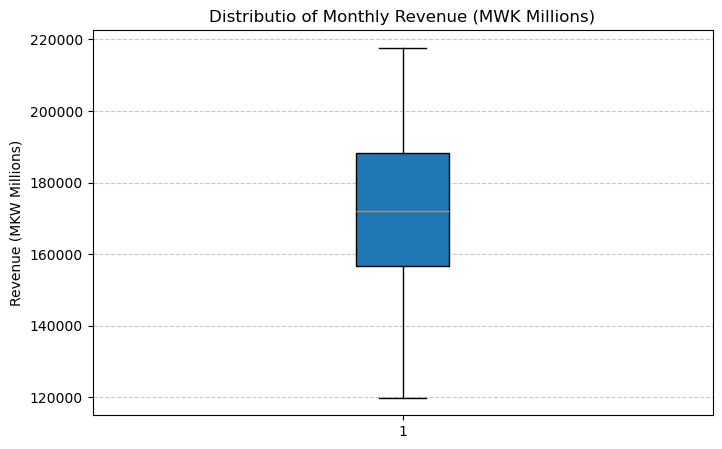

In [52]:
# Boxplot for Revenue
plt.figure(figsize = (8,5))
plt.boxplot(df['revenue_mwk_millions'], vert = True, patch_artist = True)
plt.title('Distributio of Monthly Revenue (MWK Millions)')
plt.ylabel('Revenue (MKW Millions)')
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()


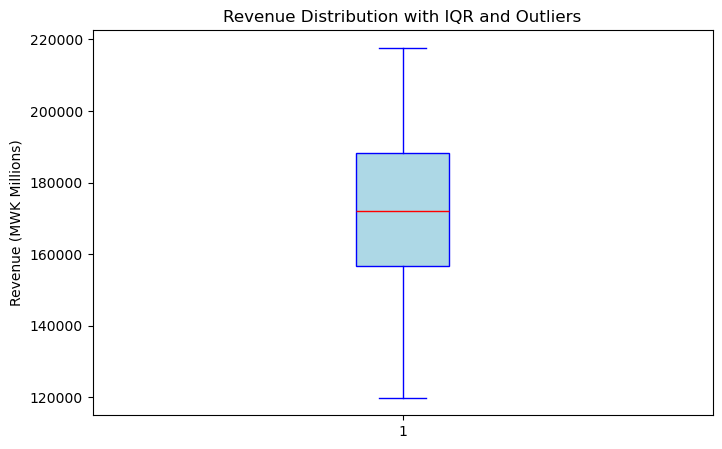

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.boxplot(df['revenue_mwk_millions'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', color='orange', markersize=8))

plt.title("Revenue Distribution with IQR and Outliers")
plt.ylabel("Revenue (MWK Millions)")
plt.show()


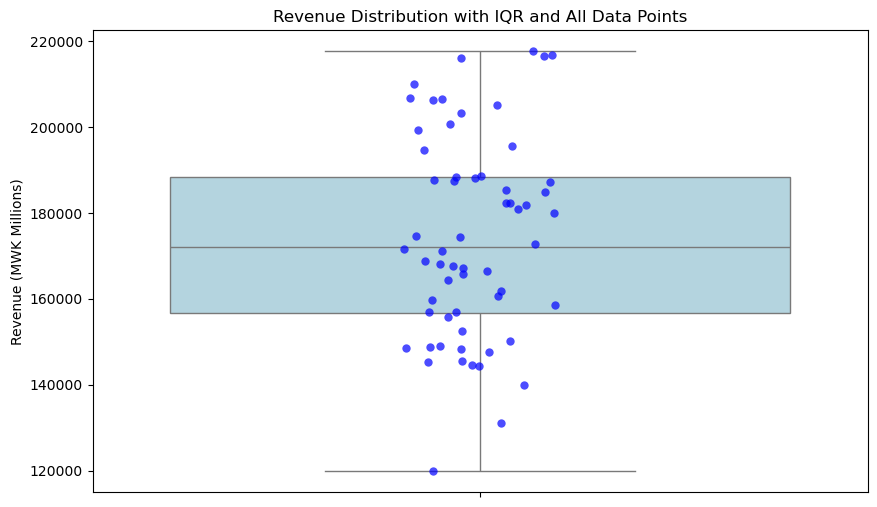

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# Create boxplot
sns.boxplot(y=df['revenue_mwk_millions'], color='lightblue')

# Overlay all individual data points
sns.stripplot(y=df['revenue_mwk_millions'], color='blue', size=6, jitter=True, alpha=0.7)

plt.title("Revenue Distribution with IQR and All Data Points")
plt.ylabel("Revenue (MWK Millions)")
plt.show()


# How to interpret your revenue boxplot:

If the median line is closer to the bottom of the box, the data is right-skewed 
(some months have very high revenue).

If the median is near the top, the data is left-skewed (some months have very low revenue).

The distance between whiskers shows overall spread; wider whiskers → more variation in monthly revenue.

Outliers highlight months where revenue was unusually high or low — these could correspond to special events, 
policy changes, or compliance drives.

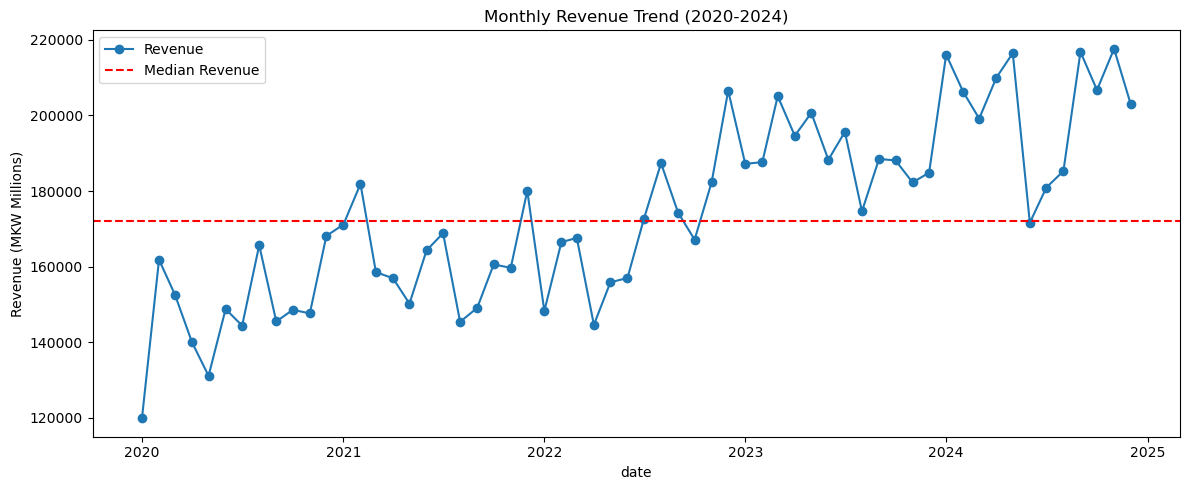

In [53]:
#Revenue Trendline
plt.figure(figsize = (12,5))
plt.plot(df['date'], df['revenue_mwk_millions'], marker = 'o', label = 'Revenue')
plt.axhline(df['revenue_mwk_millions'].median(), color = 'red', linestyle = "--", label = "Median Revenue")
plt.title('Monthly Revenue Trend (2020-2024)')
plt.xlabel('date')
plt.ylabel('Revenue (MKW Millions)')
plt.legend()
plt.tight_layout()
plt.show()

# 2024 Revenue Trend Analysis

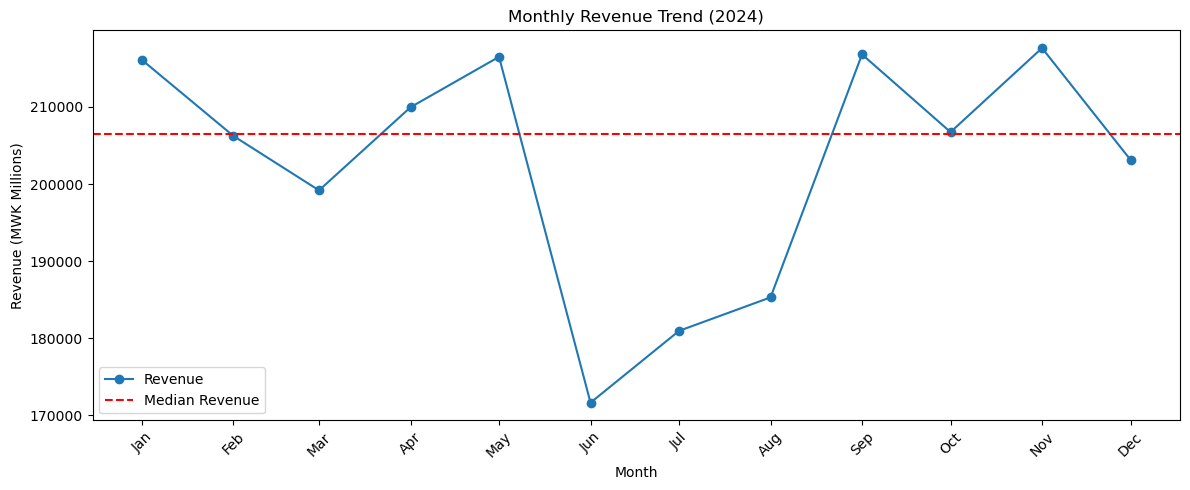

In [72]:
import matplotlib.dates as mdates

# Filter data for 2024
df_2024 = df[df['date'].dt.year == 2024]

plt.figure(figsize=(12,5))
plt.plot(df_2024['date'], df_2024['revenue_mwk_millions'], marker='o', label='Revenue')

# Add median line (only for 2024 data)
plt.axhline(df_2024['revenue_mwk_millions'].median(), color='red', linestyle="--", label="Median Revenue")

plt.title('Monthly Revenue Trend (2024)')

# Format x-axis to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))   # e.g., Jan, Feb, Mar
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # every month

plt.xticks(rotation=45)

plt.xlabel('Month')
plt.ylabel('Revenue (MWK Millions)')
plt.legend()
plt.tight_layout()
plt.show()


## 4) Data Cleaning

Fill missing macro values (ffill/bfill) and ensure chronological order.

In [86]:
# Fill missing macro data using forward/backward fill
df_sorted = df.sort_values('date').copy()
df_sorted[['gdp_growth','cpi_inflation','fx_mwk_usd']] = df_sorted[['gdp_growth','cpi_inflation','fx_mwk_usd']].ffill().bfill()

# Confirm no missing values left for modelling features
df_sorted.isnull().sum()

date                    0
year                    0
month                   0
quarter                 0
gdp_growth              0
cpi_inflation           0
fx_mwk_usd              0
fuel_price_index        0
audits_launched         0
compliance_actions      0
policy_change           0
revenue_mwk_millions    0
dtype: int64

In [87]:
df_sorted.head()

,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,1,0.046524,0.093171,756.298173,105.112003,10,32,0,119878.619410
1,2020-02-01,2020,2,1,0.043460,0.113972,756.298173,105.268892,13,27,0,161833.384408
2,2020-03-01,2020,3,1,0.053752,0.113972,763.299950,105.178146,11,15,0,152561.521181
3,2020-04-01,2020,4,2,0.053363,0.123183,763.737179,108.042704,9,23,0,139954.070513
4,2020-05-01,2020,5,2,0.035245,0.117112,760.876034,105.357513,14,26,0,131107.841131


## 5) Feature Engineering & Transformations

Create time-series features: cyclic month indicators, lag features, rolling statistics, and log-transform the target to stabilize variance.

In [93]:
# Seasonality as cyclic features
# Months are cylcic: January comes after December in a loop
# Using sine and cosine transformations helps ML models understand this cyclic nature
# month_sin and month_cos are numeric representations of the month that capture seasonality
df_sorted['month_sin'] = np.sin(2 * np.pi * df_sorted['month'] / 12)
df_sorted['month_cos'] = np.cos(2 * np.pi * df_sorted['month'] / 12)

# Lags and rolling statistics (use past data only)

# Lag means using past values of revenue as features.
# e.g. rev_lag_1 means revenue 1 month ago, rev_lag_12,  revenue 12 months ago
# this helps the model learn patterns from past months
for lag in [1,3,6,12]:
    df_sorted[f'rev_lag_{lag}'] = df_sorted['revenue_mwk_millions'].shift(lag)

# Rolling Statistics
# Computes moving averages and standard deviations over a period
# .shift(1) ensures only past data is used (prevents peeking into the future)
#rev_roll_3 means average revenue of the past 3 months
# This captures recent trends and volatility in revenue
for w in [3,6]:
    df_sorted[f'rev_roll_mean_{w}'] = df_sorted['revenue_mwk_millions'].shift(1).rolling(w).mean()
    df_sorted[f'rev_roll_std_{w}'] = df_sorted['revenue_mwk_millions'].shift(1).rolling(w).std()

# Log-transform target
# Transforms revenue to log scale using log1p (log(1+x)).
# Makes data less skewed if there are very large or small values
#Helps the model to learn patterns more easily
df_sorted['log_revenue'] = np.log1p(df_sorted['revenue_mwk_millions'])

# Drop initial rows with NaNs from lags

#Lag and rolling calculations create NaNs at the start, 
#we remove those rows to ensure clean dataset ready for modelling
df_model = df_sorted.dropna().reset_index(drop=True)
print('Model dataset shape:', df_model.shape)
df_model.head()

# Prints the shape of the dataset after all features are created.
#You now have a dataset with original revenue, lag features, 
#rolling stats, cyclic month features, and log-transformed target, ready for machine learning.

#Created Feature-rich dataset where the model can use
#past revenue or lags
#recent trends (rolling mean and std)
#seasonal patterns (month_sin & month_cos)
#Log-transformed target for stability
  # Perfect for time series forecasting              

Model dataset shape: (48, 23)


,date,year,month,quarter,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,...,month_cos,rev_lag_1,rev_lag_3,rev_lag_6,rev_lag_12,rev_roll_mean_3,rev_roll_std_3,rev_roll_mean_6,rev_roll_std_6,log_revenue
0,2021-01-01,2021,1,1,0.045330,0.100805,841.177899,107.733625,14,34,...,8.660254e-01,168128.263018,148568.512422,144380.410183,119878.619410,154776.831519,11572.121756,153308.987823,10656.438256,12.050260
1,2021-02-01,2021,2,1,0.054296,0.122292,833.317295,113.753016,15,36,...,5.000000e-01,171142.924361,147633.719117,165659.849924,161833.384408,162301.635498,12791.906581,157769.406853,11719.694089,12.111151
2,2021-03-01,2021,3,1,0.052338,0.121424,797.937906,109.785909,12,34,...,6.123234e-17,181887.774009,168128.263018,145483.172276,152561.521181,173719.653796,7232.612710,160474.060867,15246.650584,11.973800
3,2021-04-01,2021,4,2,0.044364,0.124225,788.115679,110.040673,16,26,...,-5.000000e-01,158544.913728,171142.924361,148568.512422,139954.070513,170525.204033,11683.683722,162651.017776,13511.933909,11.963542
4,2021-05-01,2021,5,2,0.046844,0.105727,813.052073,111.786654,10,17,...,-8.660254e-01,156926.956061,181887.774009,147633.719117,131107.841131,165786.547933,13967.517948,164044.091716,12129.845714,11.919797


## 6) Correlations and Visual Inspection

Compute correlation matrix to detect collinearity and relationships.

df_model.corr() calculates the Pearson Correlation Coefficient between all numeric columns in your dataset

The correlation value ranges from -1 to +1:

1 - Perfect positive correlation (as one increases, the other increases)
                                  
0 - no correlation
                                  
-1 - perfect negative correlation (as one increases, the other decreases)
                                  
numeric_only = True ensures only numeric columns are considered


corr.loc[:, ['revenue_mwk_millions']] selects correction of all features with the Target Variable
This helps identify which features are most strongly related to the Target/Revenue

.sort_values('revenue_mwk_millions', ascending=False)
Sorts features in descending order of correlation with revenue.

Features with the highest positive correlation appear first.

In [96]:
corr = df_model.corr(numeric_only=True)
corr.loc[:, ['revenue_mwk_millions']].sort_values('revenue_mwk_millions', ascending=False).head(10)

,revenue_mwk_millions
revenue_mwk_millions,1.000000
log_revenue,0.998298
policy_change,0.769851
year,0.764238
fx_mwk_usd,0.745056
fuel_price_index,0.744104
rev_roll_mean_6,0.715919
rev_roll_mean_3,0.706585
rev_lag_1,0.704129
rev_lag_12,0.569234


You are finding which features (lags, rolling stats, month sin/cos, etc.) 
are most strongly related to the current revenue.

Features at the top are strong predictors for your model.

This is a quick way to understand which past months, trends, or seasonality features matter most.

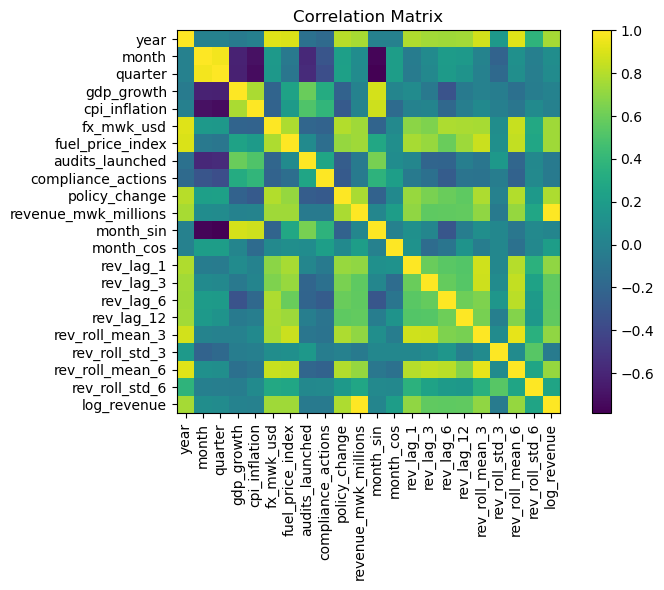

In [98]:
# Heatmap (matplotlib only)
# Shows a color scale from low (e.g., -1, negative correlation) to high (e.g., 1, positive correlation).

#Color intensity shows the strength of correlation:

#Darker or more intense color → stronger correlation

#Lighter color → weaker correlation

#Diagonal line from top-left to bottom-right is always perfect correlation (1) because a feature is perfectly correlated with itself.

#Off-diagonal cells show correlations between different features:

#Positive correlation → features increase together

#Negative correlation → one feature increases while the other decreases
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## 7) Statistical Significance (OLS) — p-values
Ordinary Least Squares Regression

Run an OLS regression with candidate predictors and use p-values (p<0.05) to select significant features. Keep core time-series predictors (lag1, seasonality) regardless of p-value.

In [99]:
# Prepare OLS features
# Include all potential factors that might affect revenue.
# Economic Factors: GDP Growth, inflation, exchange rate
# Operational factors: audits launched, compliance actions, policy changes
# Seasonality: month represented as sine/cosine
# Past revenue info: lagged revenue,rolling averages, rolling standard deviations
ols_features = [
    'gdp_growth','cpi_inflation','fx_mwk_usd','fuel_price_index',
    'audits_launched','compliance_actions','policy_change',
    'month_sin','month_cos',
    'rev_lag_1','rev_lag_3','rev_lag_6','rev_lag_12',
    'rev_roll_mean_3','rev_roll_mean_6','rev_roll_std_3','rev_roll_std_6'
]
X_ols = sm.add_constant(df_model[ols_features]) # X_ols independent variables with a constant added for the intercept
y_ols = df_model['log_revenue'] # y_ols target variable, which is log-transformed revenue
ols_res = sm.OLS(y_ols, X_ols).fit() # sm.OLS(y_ols, X_ols).fit()  fits a linear regression model
print(ols_res.summary()) # prints statistics like coefficients, how much each feature affects revenue
# and p-values - whether the effect is statistically siginificant
# R-squared - how well the model explains revenue

# Select significant variables
# Inspects P-values of each feature (ignoring the intercept)
# A p-value <0.05 means the feature has a strong, reliable effect on revenue
# only these significant features are kept for modelling
pvalues = ols_res.pvalues.drop('const', errors='ignore')
significant_feats = pvalues[pvalues < 0.05].index.tolist()
# ensure core features present
for f in ['rev_lag_1','month_sin','month_cos']:
    if f not in significant_feats:
        significant_feats.append(f)
print('\nSelected features for modeling:', significant_feats)

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     7.218
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           1.60e-06
Time:                        19:43:54   Log-Likelihood:                 74.677
No. Observations:                  48   AIC:                            -113.4
Df Residuals:                      30   BIC:                            -79.67
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.3323      0

## 8) Train/Test Split (chronological)

Reserve the last 12 months as a hold-out test set for realistic evaluation. Use the selected features from OLS for modeling.

In [100]:
# Chronological split: last 12 months as test
test_size = 12
train = df_model.iloc[:-test_size].copy()
test = df_model.iloc[-test_size:].copy()

feature_cols = significant_feats
target_col = 'log_revenue'

X_train = train[feature_cols].copy(); y_train = train[target_col].copy()
X_test = test[feature_cols].copy(); y_test = test[target_col].copy()

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (36, 5) Test shape: (12, 5)


## 9) Modeling — define algorithms and time-series CV

We will train six models: Linear, Ridge, Lasso, ElasticNet, Random Forest, Gradient Boosting. Use `TimeSeriesSplit` for cross-validation.

In [101]:
models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=42))]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.0005, max_iter=10000, random_state=42))]),
    'ElasticNet': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.0005, l1_ratio=0.5, max_iter=10000, random_state=42))]),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

tscv = TimeSeriesSplit(n_splits=3)

# Cross-validation (time-series): negative RMSE scoring and convert to positive RMSE
cv_rows = []
for name, model in models.items():
    neg_rmse = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    rmse_scores = -neg_rmse
    cv_rows.append({'model': name, 'cv_rmse_mean': rmse_scores.mean(), 'cv_rmse_std': rmse_scores.std()})
import pandas as pd
cv_df = pd.DataFrame(cv_rows).sort_values('cv_rmse_mean')
cv_df

,model,cv_rmse_mean,cv_rmse_std
4,RandomForest,0.095190,0.060083
5,GradientBoosting,0.116135,0.054797
1,Ridge,0.134603,0.082131
2,Lasso,0.141648,0.083897
3,ElasticNet,0.143272,0.084274
0,LinearRegression,0.145021,0.084682


## 10) Fit models on full training set and evaluate on the hold-out test set

Compute RMSE, MAPE and R² on actual (expm1) scale.

In [105]:
holdout_rows = []
fitted = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    
    # Calculate RMSE manually by taking square root of MSE
    # This works with older scikit-learn versions
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Take square root to get RMSE
    
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    holdout_rows.append({'model': name, 'test_rmse': rmse, 'test_mape': mape, 'test_r2': r2})
    fitted[name] = model

holdout_df = pd.DataFrame(holdout_rows).sort_values(['test_mape','test_rmse']).reset_index(drop=True)
holdout_df

,model,test_rmse,test_mape,test_r2
0,Ridge,19471.750428,0.079436,-0.730118
1,LinearRegression,19838.916325,0.080852,-0.795981
2,ElasticNet,19875.229020,0.081112,-0.802561
3,Lasso,19919.520658,0.081400,-0.810604
4,RandomForest,21240.514285,0.088169,-1.058713
5,GradientBoosting,22897.045289,0.093253,-1.392350


## 11) Select best model and visualize predictions

Choose the model with the lowest MAPE (or RMSE). Plot actual vs predicted for the test period.

Best model chosen: Ridge


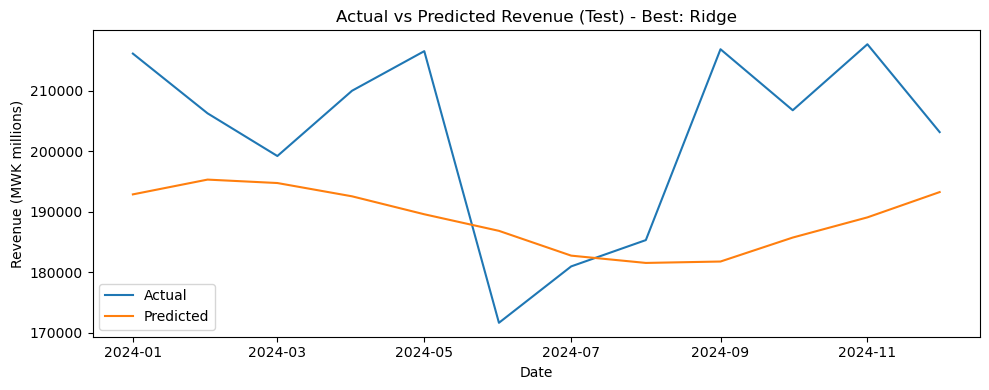

In [106]:
best_model_name = holdout_df.loc[0, 'model']
best_model = fitted[best_model_name]
print('Best model chosen:', best_model_name)

# Plot actual vs predicted
y_pred_best = np.expm1(best_model.predict(X_test))
y_true = np.expm1(y_test)

plt.figure(figsize=(10,4))
plt.plot(test['date'], y_true, label='Actual')
plt.plot(test['date'], y_pred_best, label='Predicted')
plt.title(f'Actual vs Predicted Revenue (Test) - Best: {best_model_name}')
plt.xlabel('Date'); plt.ylabel('Revenue (MWK millions)'); plt.legend(); plt.tight_layout(); plt.show()

## 12) Recursive multi-step forecasting (12 months)

Create future features (seasonality + macro assumptions), then forecast recursively using the best model. In practice, supply macro forecasts from official projections.

,date,forecast_revenue_mwk_millions
0,2025-01-01,194911.578415
1,2025-02-01,195356.908005
2,2025-03-01,194101.055299
3,2025-04-01,191587.067090
4,2025-05-01,188317.534324
5,2025-06-01,184969.723460
6,2025-07-01,182413.788149
7,2025-08-01,181284.344178
8,2025-09-01,181850.646654
9,2025-10-01,183971.649633


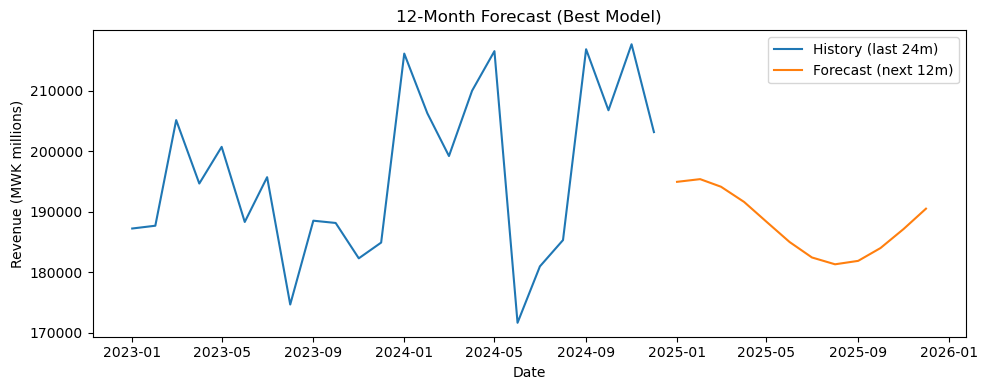

In [107]:
# Prepare future feature frame for next 12 months
last_date = df_sorted['date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

future = pd.DataFrame({'date': future_dates, 'month': future_dates.month})
future['month_sin'] = np.sin(2 * np.pi * future['month'] / 12)
future['month_cos'] = np.cos(2 * np.pi * future['month'] / 12)
future['policy_change'] = 1  # assume policy persists

# For macros, use recent averages (or replace with official forecasts)
recent = df_sorted.tail(12)
future['gdp_growth'] = recent['gdp_growth'].mean()
future['cpi_inflation'] = recent['cpi_inflation'].mean()
future['fx_mwk_usd'] = recent['fx_mwk_usd'].mean() + np.arange(1,13) * (recent['fx_mwk_usd'].diff().mean())
future['fuel_price_index'] = recent['fuel_price_index'].mean()
future['audits_launched'] = int(recent['audits_launched'].mean())
future['compliance_actions'] = int(recent['compliance_actions'].mean())

# Use history buffer to compute lags recursively
history = df_sorted[['date','revenue_mwk_millions']].copy()
preds = []
for dt in future_dates:
    tmp = {}
    tmp['rev_lag_1'] = history['revenue_mwk_millions'].iloc[-1]
    tmp['rev_lag_3'] = history['revenue_mwk_millions'].iloc[-3]
    tmp['rev_lag_6'] = history['revenue_mwk_millions'].iloc[-6]
    tmp['rev_lag_12'] = history['revenue_mwk_millions'].iloc[-12] if len(history)>=12 else history['revenue_mwk_millions'].iloc[0]
    tmp['rev_roll_mean_3'] = history['revenue_mwk_millions'].iloc[-3:].mean()
    tmp['rev_roll_mean_6'] = history['revenue_mwk_millions'].iloc[-6:].mean()
    tmp['rev_roll_std_3'] = history['revenue_mwk_millions'].iloc[-3:].std()
    tmp['rev_roll_std_6'] = history['revenue_mwk_millions'].iloc[-6:].std()

    cal = future.loc[future['date']==dt].iloc[0].to_dict()
    row = {**tmp,
           'gdp_growth': cal['gdp_growth'],
           'cpi_inflation': cal['cpi_inflation'],
           'fx_mwk_usd': cal['fx_mwk_usd'],
           'fuel_price_index': cal['fuel_price_index'],
           'audits_launched': cal['audits_launched'],
           'compliance_actions': cal['compliance_actions'],
           'policy_change': cal['policy_change'],
           'month_sin': cal['month_sin'],
           'month_cos': cal['month_cos']
          }
    X_row = pd.DataFrame([row])[feature_cols]
    y_log = best_model.predict(X_row)[0]
    y_val = np.expm1(y_log)
    preds.append({'date': dt, 'forecast_revenue_mwk_millions': y_val})
    history = pd.concat([history, pd.DataFrame({'date':[dt], 'revenue_mwk_millions':[y_val]})], ignore_index=True)

forecast_df = pd.DataFrame(preds)
display(forecast_df)
plt.figure(figsize=(10,4))
plt.plot(df_sorted['date'].tail(24), df_sorted['revenue_mwk_millions'].tail(24), label='History (last 24m)')
plt.plot(forecast_df['date'], forecast_df['forecast_revenue_mwk_millions'], label='Forecast (next 12m)')
plt.title('12-Month Forecast (Best Model)')
plt.xlabel('Date'); plt.ylabel('Revenue (MWK millions)'); plt.legend(); plt.tight_layout(); plt.show()

## 13) Save model & production notes

- Save the trained model (joblib) and maintain a versioned dataset snapshot for reproducibility.
- Schedule monthly re-training and monitor forecast drift (MAPE thresholds).
- Document data lineage, assumptions for macro inputs, and governance.

**Example commands** (uncomment to run in real environment):

```python
# import joblib
# joblib.dump(best_model, 'revenue_model_best.joblib')
```

## 14) Classroom exercises and extensions

1. Replace simulated data with your Actual Tax Administration monthly revenue and macro variables; re-run pipeline.
2. Add additional features: filing deadlines, one-off policy shocks, e-invoice rollout dummy.
3. Try more algorithms (XGBoost, Prophet, SARIMAX) and compare performance.
4. Build a Power BI dashboard that reads the forecast CSV and displays MTD/YTD comparisons.

---

**Notebook files generated alongside this notebook:**
- `revenue_forecasting_files/tax_revenue_simulated.csv` (simulated data)
- When you fit models locally you can save: `revenue_model_best.joblib`
